In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv('/gdrive/My Drive/samsung/mealData_meal_train2.csv',engine='python',encoding='euc-kr', dtype={'trade_price_idx_value':'float'}) 
#/content/drive/My Drive/samsung/mealData_meal_test.csv
df2 = pd.read_csv('/gdrive/My Drive/samsung/mealData_meal_test.csv',engine='python',encoding='euc-kr', dtype={'trade_price_idx_value':'float'}) 

평일 Data만 추출

In [0]:
df['weekday'] = pd.to_datetime(df["SELL_DATE"]).dt.dayofweek
df=df[df['weekday']!= 5]

df2['weekday'] = pd.to_datetime(df2["SELL_DATE"]).dt.dayofweek
df2=df2[df2['weekday']!= 5]

In [0]:
train = df.groupby('SELL_DATE').sum()['QUANTITY']
test = df2.groupby('SELL_DATE').sum()['QUANTITY']

a = list(set(df.SELL_DATE))
a.sort()

trainset ={'SELL_DATE': a , "QUANTITY":list(train)}
trainset = pd.DataFrame(trainset)
trainset['SELL_DATE'] = pd.to_datetime(trainset.SELL_DATE)
trainset.sort_values(by = ['SELL_DATE'], inplace=True, ascending=True)

a = list(set(df2.SELL_DATE))
a.sort()

testset ={'SELL_DATE': a , "QUANTITY":list(test)}
testset = pd.DataFrame(testset)
testset['SELL_DATE'] = pd.to_datetime(testset.SELL_DATE)
testset.sort_values(by = ['SELL_DATE'], inplace=True, ascending=True)

공휴일 Na값 -> 평균 값

In [0]:
mean = int(train.mean())
mean2 = int(test.mean())
train_holiday = ['2018-01-01','2018-02-15','2018-02-16','2018-03-01','2018-05-22','2018-06-06','2018-08-15',
           '2018-09-24','2018-09-25','2018-10-03','2018-10-09','2018-12-25','2019-01-01',
           '2019-02-04','2019-02-05','2019-02-06','2019-03-01']
test_holiday = ['2019-06-06']

temp = {"SELL_DATE": train_holiday , "QUANTITY":mean}
temp = pd.DataFrame(temp)

temp['SELL_DATE'] = pd.to_datetime(temp.SELL_DATE)
trainset = trainset.append(temp,ignore_index=True)
trainset.sort_values(by = ['SELL_DATE'], inplace=True, ascending=True)

temp2 = {"SELL_DATE":test_holiday , "QUANTITY":mean2}
temp2 = pd.DataFrame(temp2)
temp2['SELL_DATE'] = pd.to_datetime(temp2.SELL_DATE)
testset = testset.append(temp2,ignore_index=True)
testset.sort_values(by = ['SELL_DATE'], inplace=True, ascending=True)
testset

In [0]:
trainset.set_index(trainset['SELL_DATE'],inplace=True)
trainset = trainset.drop(['SELL_DATE'],axis=1)

testset.set_index(testset['SELL_DATE'],inplace=True)
testset = testset.drop(['SELL_DATE'],axis=1)

trainset.info()

In [0]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(trainset)
test_sc = sc.transform(testset)

In [0]:
train_sc_df = pd.DataFrame(train_sc, columns=['QUANTITY'], index=trainset.index)
test_sc_df = pd.DataFrame(test_sc, columns=['QUANTITY'], index=testset.index)
train_sc_df.head()

일주일 단위 -> 평일만 (5일)

In [9]:
for s in range(1, 6):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['QUANTITY'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['QUANTITY'].shift(s)
train_sc_df.head(13)

,QUANTITY,shift_1,shift_2,shift_3,shift_4,shift_5
SELL_DATE,,,,,,
2018-01-01,0.700670,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.770115,0.700670,NaN,NaN,NaN,NaN
2018-01-03,0.753831,0.770115,0.700670,NaN,NaN,NaN
2018-01-04,0.669540,0.753831,0.770115,0.700670,NaN,NaN
2018-01-05,0.585249,0.669540,0.753831,0.770115,0.700670,NaN
2018-01-08,0.815613,0.585249,0.669540,0.753831,0.770115,0.700670
2018-01-09,0.731801,0.815613,0.585249,0.669540,0.753831,0.770115
2018-01-10,0.723659,0.731801,0.815613,0.585249,0.669540,0.753831
2018-01-11,0.633621,0.723659,0.731801,0.815613,0.585249,0.669540


In [0]:
X_train = train_sc_df.dropna().drop('QUANTITY', axis=1)
y_train = train_sc_df.dropna()[['QUANTITY']] 

X_test = test_sc_df.dropna().drop('QUANTITY', axis=1)
y_test = test_sc_df.dropna()[['QUANTITY']]

In [0]:
X_train = X_train.values #(354, 5)
X_test= X_test.values 
y_train = y_train.values#(354, 1)
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], 5, 1)
X_test_t = X_test.reshape(X_test.shape[0], 5, 1)

In [131]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense , Activation
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(5, input_shape=(5, 1))) # (timestep, feature)
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam')
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [128]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
model.fit(X_train_t, y_train, epochs=5,
          batch_size=5, verbose=1, callbacks=[early_stop])

ValueError: ignored

In [54]:
train_sc_df.describe()

,QUANTITY,shift_1,shift_2,shift_3,shift_4,shift_5
count,359.000000,358.000000,357.000000,356.000000,355.000000,354.000000
mean,0.700997,0.701143,0.700947,0.700615,0.700054,0.699207
std,0.138333,0.138500,0.138644,0.138698,0.138488,0.137759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.628592,0.627993,0.627395,0.627275,0.627155,0.627035
50%,0.700670,0.700670,0.700670,0.700670,0.700670,0.700670
75%,0.782567,0.782807,0.783046,0.782328,0.782088,0.781489
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.988985


Text(0.5, 1.0, 'real_data vs lstm predict: $Y_i$ vs $\\hat{Y}_i$')

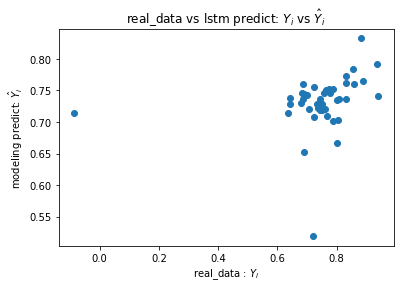

In [121]:
import matplotlib.pyplot as plt
y_pred = model.predict(X_test_t, batch_size=5)
plt.scatter(y_test, y_pred)
plt.xlabel("real_data : $Y_i$")
plt.ylabel("modeling predict: $\hat{Y}_i$")
plt.title("real_data vs lstm predict: $Y_i$ vs $\hat{Y}_i$")

In [122]:
from sklearn.metrics import mean_squared_error , r2_score
print("mse :",mean_squared_error(y_test, y_pred))
print("r^2 : ",r2_score(y_test, y_pred))

mse : 0.020767007252513934
r^2 :  0.04411483441075037


--- Linear regresssion---


In [123]:
from sklearn.linear_model import LinearRegression
obj = LinearRegression()
lrmodel = obj.fit(X_train , y_train)
y_lr_predict = lrmodel.predict(X_test)
y_lr_predict
print("mse :",mean_squared_error(y_test, y_lr_predict))
print("r^2 : ",r2_score(y_test, y_lr_predict))

mse : 0.02212410240043566
r^2 :  -0.018350936627803627


Text(0.5, 1.0, 'real_data vs Linearregression predict: $Y_i$ vs $\\hat{Y}_i$')

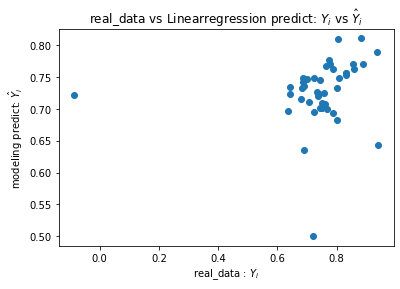

In [75]:
plt.scatter(y_test, y_lr_predict)
plt.xlabel("real_data : $Y_i$")
plt.ylabel("modeling predict: $\hat{Y}_i$")
plt.title("real_data vs Linearregression predict: $Y_i$ vs $\hat{Y}_i$")

In [103]:
df = pd.DataFrame({'real': y_test.reshape(43) , 'lstm': y_pred.reshape(43), 'linearregression': y_lr_predict.reshape(43)})
df.corr()

,real,lstm,linearregression
real,1.000000,0.135553,0.160788
lstm,0.135553,1.000000,0.821281
linearregression,0.160788,0.821281,1.000000


In [134]:
df.columns

Index(['SELL_DATE', 'CUSTOMER_ID', 'BRAND', 'MENU', 'PRICE', 'QUANTITY'], dtype='object')